In [59]:
from datetime import datetime
import settings.config_movie_lens as cfg
import pandas as pd
import numpy as np


preprocessed_dataset_folder = cfg.preprocessed_dataset_folder
individual_rs_strategy = cfg.individual_rs_strategy
aggregation_strategies = cfg.aggregation_strategies
recommendations_number = cfg.recommendations_number
individual_rs_validation_folds_k = cfg.individual_rs_validation_folds_k
group_rs_evaluation_folds_k = cfg.group_rs_evaluation_folds_k
evaluation_strategy = cfg.evaluation_strategy
metrics = cfg.metrics
group_types = cfg.group_types

display(cfg.dataset_folder,cfg.preprocessed_dataset_folder)

'ml-1m'

'preprocessed_dataset'

In [60]:
import pandas as pd
ratings_df = pd.read_csv(preprocessed_dataset_folder+"/ratings.csv", nrows=10000)

import pickle

group_composition = pickle.load(open(preprocessed_dataset_folder+"/group_composition.pkl", "rb"))

ratings_df

user  item  rating
0        1  1193       5
1        1   661       3
2        1   914       3
3        1  3408       4
4        1  2355       5
...    ...   ...     ...
9995    75  2162       4
9996    75  2090       5
9997    75  2092       3
9998    75  2096       1
9999    75  1367       3

[10000 rows x 3 columns]

In [61]:
group_composition

{0: {'group_size': 2,
  'group_similarity': 'random',
  'group_members': [4805, 5428]},
 1: {'group_size': 2,
  'group_similarity': 'random',
  'group_members': [5251, 146]},
 2: {'group_size': 2,
  'group_similarity': 'random',
  'group_members': [3916, 4539]},
 3: {'group_size': 2,
  'group_similarity': 'random',
  'group_members': [2059, 5558]},
 4: {'group_size': 2,
  'group_similarity': 'random',
  'group_members': [1789, 463]},
 5: {'group_size': 2,
  'group_similarity': 'random',
  'group_members': [3234, 4068]},
 6: {'group_size': 2,
  'group_similarity': 'random',
  'group_members': [5216, 4855]},
 7: {'group_size': 2,
  'group_similarity': 'random',
  'group_members': [339, 5736]},
 8: {'group_size': 2,
  'group_similarity': 'random',
  'group_members': [153, 4515]},
 9: {'group_size': 2,
  'group_similarity': 'random',
  'group_members': [3450, 2157]},
 10: {'group_size': 3,
  'group_similarity': 'random',
  'group_members': [707, 2380, 379]},
 11: {'group_size': 3,
  'group

## Train individual RS / Prepare groundtruth

In [62]:
import pickle
import os
from individual_rs.individual_rs import IndividualRS
from utils.utility_functions import create_per_user_group_choices

import warnings
warnings.filterwarnings('ignore')
# General pipeline

# creating train-test folds
# split stratified on the users 

from sklearn.model_selection import StratifiedKFold
import itertools

if group_types == "SYNTHETIC":
    print(datetime.now(), "Creating folds")
    # skf = StratifiedKFold(n_splits=group_rs_evaluation_folds_k, random_state=None, shuffle=True)
    skf = StratifiedKFold(n_splits=group_rs_evaluation_folds_k, random_state=42, shuffle=True)

    print(datetime.now(), "Folds created!")
    current_fold = 0
    for train_index, test_index in skf.split(ratings_df, ratings_df['user']):
        print(">>> Start processing fold: Train", len(train_index), "Test:", len(test_index))

        # split train and test df
        train_df = ratings_df.iloc[train_index]
        test_df = ratings_df.iloc[test_index]

        # getting user-items pairs in the training set
        train_set_pairs = set(list(zip(train_df['user'].values,train_df['item'].values)))

        # create test_complete_df with all the possible user-items pairs in the test_df
        user_set = set(test_df['user'].values)
        item_set = set(test_df['item'].values)
        all_ui_values = list(itertools.product(user_set, item_set))
        test_pred_df = pd.DataFrame(all_ui_values, columns=['user', 'item'])

    #     print(datetime.now(), "Extended test df")
    #     display(test_pred_df)

        print(datetime.now(), "Train individual RS and get predictions")
        # train individual rs and get predictions
        test_pred_df = IndividualRS.train_individual_rs_and_get_predictions(train_df, test_pred_df)

        #correction for train set records (assuming repeated recommendations provide no value, therefore predicted_rating=0)
        train_set_pairs = train_set_pairs.intersection(set(all_ui_values))
        test_pred_df.set_index(["user","item"], inplace=True)
        test_pred_df.loc[train_set_pairs,"predicted_rating"] = 0.0
        test_pred_df.reset_index(inplace=True)

        path_to_fold = preprocessed_dataset_folder+"/fold_"+str(current_fold)

        if not os.path.exists(path_to_fold):
            os.mkdir(path_to_fold)

        pickle.dump(train_df, open(path_to_fold+"/train_df.pkl", "wb"))
        pickle.dump(test_df, open(path_to_fold+"/test_df.pkl", "wb"))
        pickle.dump(test_pred_df, open(path_to_fold+"/test_pred_df.pkl", "wb"))

        current_fold = current_fold + 1

else:
    print("ERROR: incorrect config file!")
print(datetime.now(), "Done!")
test_pred_df


2023-02-15 18:45:49.444669 Creating folds
2023-02-15 18:45:49.444669 Folds created!
>>> Start processing fold: Train 8000 Test: 2000
2023-02-15 18:45:49.492698 Train individual RS and get predictions
LENSKIT_CF_ITEM
training
nNeighbors hyperparameter:1
evaluating predictions
Done!
>>> Start processing fold: Train 8000 Test: 2000
2023-02-15 18:46:22.723861 Train individual RS and get predictions
LENSKIT_CF_ITEM
training
nNeighbors hyperparameter:5
evaluating predictions
Done!
>>> Start processing fold: Train 8000 Test: 2000
2023-02-15 18:46:55.462290 Train individual RS and get predictions
LENSKIT_CF_ITEM
training
nNeighbors hyperparameter:5
evaluating predictions
Done!
>>> Start processing fold: Train 8000 Test: 2000
2023-02-15 18:47:25.863772 Train individual RS and get predictions
LENSKIT_CF_ITEM
training
nNeighbors hyperparameter:1
evaluating predictions
Done!
>>> Start processing fold: Train 8000 Test: 2000
2023-02-15 18:47:56.098799 Train individual RS and get predictions
LENSKIT_

user  item  predicted_rating
0         1     1          0.000000
1         1     2          3.797351
2         1     3          3.630367
3         1  3257          2.796290
4         1     5               NaN
...     ...   ...               ...
76720    75  2034          2.385499
76721    75  1219          4.829939
76722    75  2040               NaN
76723    75  3255          3.771835
76724    75  2042               NaN

[76725 rows x 3 columns]

# Construct group recommendations

In [63]:
from utils.utility_functions import generate_group_recommendations_forall_groups

import os
import warnings
warnings.filterwarnings('ignore')
lst = os.listdir(preprocessed_dataset_folder)
folds = [i for i in lst if (os.path.isdir(preprocessed_dataset_folder+"/"+i) and i.startswith("fold"))]
folds = ["fold_0"] # Only do fold_0, quicker testing

for f in folds:
    current_fold = int(f.replace("fold_",""))
    path_to_fold = preprocessed_dataset_folder+"/"+f
    
    if group_types == "SYNTHETIC":
        train_df = pickle.load(open(path_to_fold+"/train_df.pkl", "rb"))
        test_df = pickle.load(open(path_to_fold+"/test_df.pkl", "rb"))
        test_pred_df = pickle.load(open(path_to_fold+"/test_pred_df.pkl", "rb"))
    else:
        print("ERROR: incorrect config file!")     

    print(datetime.now(), f+": Generate GRS for all the aggregation strategies and all the groups")
    # - generate the recommendations for all the aggregation strategies and all the groups
    # print(group_composition)
    
    group_recommendations = generate_group_recommendations_forall_groups(test_pred_df, group_composition, cfg.recommendations_number)
    print(datetime.now(), f+": Done")
    print(group_recommendations)
    
    pickle.dump(group_recommendations, open(path_to_fold+"/group_recommendations.pkl", "wb"))



2023-02-15 18:51:05.989369 fold_0: Generate GRS for all the aggregation strategies and all the groups
2023-02-15 18:51:07.026713 fold_0: Done
{0: {'ADD': [], 'MUL': [], 'LMS': [], 'MPL': [], 'FAI': []}, 1: {'ADD': [], 'MUL': [], 'LMS': [], 'MPL': [], 'FAI': []}, 2: {'ADD': [], 'MUL': [], 'LMS': [], 'MPL': [], 'FAI': []}, 3: {'ADD': [], 'MUL': [], 'LMS': [], 'MPL': [], 'FAI': []}, 4: {'ADD': [], 'MUL': [], 'LMS': [], 'MPL': [], 'FAI': []}, 5: {'ADD': [], 'MUL': [], 'LMS': [], 'MPL': [], 'FAI': []}, 6: {'ADD': [], 'MUL': [], 'LMS': [], 'MPL': [], 'FAI': []}, 7: {'ADD': [], 'MUL': [], 'LMS': [], 'MPL': [], 'FAI': []}, 8: {'ADD': [], 'MUL': [], 'LMS': [], 'MPL': [], 'FAI': []}, 9: {'ADD': [], 'MUL': [], 'LMS': [], 'MPL': [], 'FAI': []}, 10: {'ADD': [], 'MUL': [], 'LMS': [], 'MPL': [], 'FAI': []}, 11: {'ADD': [], 'MUL': [], 'LMS': [], 'MPL': [], 'FAI': []}, 12: {'ADD': [], 'MUL': [], 'LMS': [], 'MPL': [], 'FAI': []}, 13: {'ADD': [], 'MUL': [], 'LMS': [], 'MPL': [], 'FAI': []}, 14: {'ADD': [

# Evaluate group recommendations
### Define evaluation variants

In [19]:
evaluation_variants = [
   {
       "evaluation_strategy": "COUPLED",
       "binarize_feedback": True,
       "binarize_feedback_positive_threshold": 4.0,
       "inverse_propensity_debiasing": False,
       "inverse_propensity_gamma": 0.0
   },
   {
       "evaluation_strategy": "COUPLED",
       "binarize_feedback": True,
       "binarize_feedback_positive_threshold": 4.0,
       "inverse_propensity_debiasing": True,
       "inverse_propensity_gamma": 0.5
   },
   {
       "evaluation_strategy": "COUPLED",
       "binarize_feedback": False,
       "inverse_propensity_debiasing": False,
       "inverse_propensity_gamma": 0.0
   },
   {
       "evaluation_strategy": "COUPLED",
       "binarize_feedback": False,
       "inverse_propensity_debiasing": True,
       "inverse_propensity_gamma": 0.5
   },    
]
# evaluation_variants = [
#     {
#         "evaluation_strategy": "DECOUPLED",
#         "binarize_feedback": True,
#         "binarize_feedback_positive_threshold": 4.0,
#         "feedback_polarity_debiasing": 0.0    
#     },
#     {
#         "evaluation_strategy": "DECOUPLED",
#         "binarize_feedback": True,
#         "binarize_feedback_positive_threshold": 3.0,
#         "feedback_polarity_debiasing": 0.0    
#     },    
#     {
#         "evaluation_strategy": "DECOUPLED",
#         "binarize_feedback": False,
#         "binarize_feedback_positive_threshold": 4.0,
#         "feedback_polarity_debiasing": 0.0
#     },
#     {
#         "evaluation_strategy": "DECOUPLED",
#         "binarize_feedback": False,
#         "binarize_feedback_positive_threshold": 4.0,
#         "feedback_polarity_debiasing": -2.0   
#     },
#     {
#         "evaluation_strategy": "DECOUPLED",
#         "binarize_feedback": False,
#         "binarize_feedback_positive_threshold": 4.0,
#         "feedback_polarity_debiasing": -4.0
#     },    
# ]

In [20]:
import os
import time
import json
from utils.utility_functions import calculate_inverse_propensity_score,calculate_inverse_propensity_score_user_normalization
from utils.utility_functions import evaluate_group_recommendations_forall_groups

import warnings
warnings.filterwarnings('ignore')

lst = os.listdir(preprocessed_dataset_folder)
folds = [i for i in lst if (os.path.isdir(preprocessed_dataset_folder+"/"+i) and i.startswith("fold"))]

for ev in evaluation_variants:
    for i in ev.keys():
        setattr(cfg, i, ev[i])

    evaluations = list()
    for f in folds:
        current_fold = int(f.replace("fold_",""))
        path_to_fold = preprocessed_dataset_folder+"/"+f
        
        if group_types == "SYNTHETIC":
            train_df = pickle.load(open(path_to_fold+"/train_df.pkl", "rb"))
            test_df = pickle.load(open(path_to_fold+"/test_df.pkl", "rb"))
            test_pred_df = pickle.load(open(path_to_fold+"/test_pred_df.pkl", "rb"))
        else:
            print("ERROR: incorrect config file!")  
            
        group_recommendations = pickle.load(open(path_to_fold+"/group_recommendations.pkl", "rb"))

        # - evaluate the recommendations
        if cfg.evaluation_strategy == "COUPLED":
            ground_truth = test_df
        else:
            ground_truth = test_pred_df.rename(columns={"predicted_rating": "rating"}, errors="raise")

        if cfg.inverse_propensity_debiasing == True and cfg.evaluation_strategy == "COUPLED":
            propensity_per_item = calculate_inverse_propensity_score(ratings_df, train_df, cfg.inverse_propensity_gamma)
            per_user_propensity_normalization_term = calculate_inverse_propensity_score_user_normalization(propensity_per_item, test_df)
        else:
            #dummies to simplify downstream code
            propensity_per_item = pd.Series({"propensity_score":1.0})
            per_user_propensity_normalization_term = None

        print(datetime.now(), f+": Evaluate Group recommendations")
        fold_group_evaluations = evaluate_group_recommendations_forall_groups(
            ground_truth, 
            group_recommendations, 
            group_composition, 
            propensity_per_item, 
            per_user_propensity_normalization_term,
            current_fold,
            cfg.evaluation_ground_truth,            
            cfg.binarize_feedback_positive_threshold,
            cfg.binarize_feedback,
            cfg.feedback_polarity_debiasing 
        )
        print(datetime.now(), "Fold Evaluation DONE")
        #display(fold_group_evaluations)

        evaluations = evaluations + fold_group_evaluations
        #current_fold = current_fold + 1
    eval_df = pd.DataFrame.from_records(evaluations)  
    
    
    
    path_to_eval_folder = preprocessed_dataset_folder+"/eval_"+str(time.time())
    eval_parameters = {key:cfg.__dict__[key] for key in cfg.__dict__.keys() if not (key.startswith('__') or key.startswith('_'))}

    if not os.path.exists(path_to_eval_folder):
        os.mkdir(path_to_eval_folder)
        
    
    pickle.dump(eval_parameters, open(path_to_eval_folder+"/eval_parameters.pkl", "wb"))    
    pickle.dump(eval_df, open(path_to_eval_folder+"/eval_df.pkl", "wb"))
    pickle.dump(group_composition, open(path_to_eval_folder+"/group_composition.pkl", "wb"))
    #for human readability
    with open(path_to_eval_folder+"/eval_parameters.json" , "w" ) as write:
        json.dump( eval_parameters , write )        

2023-02-15 18:09:13.458018 fold_0: Evaluate Group recommendations
2023-02-15 18:09:22.607290 Fold Evaluation DONE
2023-02-15 18:09:22.614291 fold_1: Evaluate Group recommendations
2023-02-15 18:09:31.535708 Fold Evaluation DONE
2023-02-15 18:09:31.543706 fold_2: Evaluate Group recommendations
2023-02-15 18:09:40.315159 Fold Evaluation DONE
2023-02-15 18:09:40.322157 fold_3: Evaluate Group recommendations
2023-02-15 18:09:49.251974 Fold Evaluation DONE
2023-02-15 18:09:49.261887 fold_4: Evaluate Group recommendations
2023-02-15 18:09:58.084362 Fold Evaluation DONE
2023-02-15 18:09:58.208659 fold_0: Evaluate Group recommendations


KeyError: 4805

# Show how individual evaluation runs differs from each other
- only show parameters with non-uniform values

In [7]:
import os
import time
import json
lst = os.listdir(preprocessed_dataset_folder)
results = [i for i in lst if (os.path.isdir(preprocessed_dataset_folder+"/"+i) and i.startswith("eval"))]
list(enumerate(results))

[(0, 'eval_1663280669.8002677'),
 (1, 'eval_1663281533.6065123'),
 (2, 'eval_1663282398.1663923'),
 (3, 'eval_1663283262.6141398'),
 (4, 'eval_1663284373.157593'),
 (5, 'eval_1663285470.9824817'),
 (6, 'eval_1663286563.1802847'),
 (7, 'eval_1663287655.3001313'),
 (8, 'eval_1663288542.7618687'),
 (9, 'eval_1663289646.3467824'),
 (10, 'eval_1663294119.2699444'),
 (11, 'eval_1663298606.152506'),
 (12, 'eval_1663303136.2728064'),
 (13, 'eval_1663307731.5719433'),
 (14, 'eval_1663436168.0032027'),
 (15, 'eval_1663441335.4183762'),
 (16, 'eval_1663446476.9394755')]

In [8]:
lst = os.listdir(preprocessed_dataset_folder)
results = [i for i in lst if (os.path.isdir(preprocessed_dataset_folder+"/"+i) and i.startswith("eval"))]

eval_params_list = []
for r in results:
    path_to_eval_folder = preprocessed_dataset_folder + "/" + r
    eval_params = pickle.load(open(path_to_eval_folder+"/eval_parameters.pkl", "rb"))
    eval_params_list.append(eval_params)

parameters_df = pd.DataFrame(eval_params_list)
parameters_df.index = results
keep_col = []
parameters_df = parameters_df.astype(str)
for c in parameters_df.columns:
    if len(parameters_df.loc[:,c].unique()) > 1:
        keep_col.append(True)
    else:
        keep_col.append(False)
parameters_df_relevant = parameters_df.loc[:,keep_col]  
parameters_df_relevant

evaluation_strategy inverse_propensity_debiasing  \
eval_1663280669.8002677             COUPLED                        False   
eval_1663281533.6065123             COUPLED                        False   
eval_1663282398.1663923             COUPLED                        False   
eval_1663283262.6141398             COUPLED                        False   
eval_1663284373.157593              COUPLED                         True   
eval_1663285470.9824817             COUPLED                         True   
eval_1663286563.1802847             COUPLED                         True   
eval_1663287655.3001313             COUPLED                         True   
eval_1663288542.7618687             COUPLED                        False   
eval_1663289646.3467824             COUPLED                         True   
eval_1663294119.2699444           DECOUPLED                         True   
eval_1663298606.152506            DECOUPLED                         True   
eval_1663303136.2728064           DECOUPLED                         True   
eval_1663307731.5719433           DECOUPLED                         True   
eval_1663436168.0032027           DECOUPLED                         True   
eval_1663441335.4183762           DECOUPLED                         True   
eval_1663446476.9394755           DECOUPLED                         True   

                        inverse_propensity_gamma binarize_feedback  \
eval_1663280669.8002677                      0.0              True   
eval_1663281533.6065123                      0.0              True   
eval_1663282398.1663923                      0.0              True   
eval_1663283262.6141398                      0.0              True   
eval_1663284373.157593                       0.1              True   
eval_1663285470.9824817                      0.5              True   
eval_1663286563.1802847                      1.0              True   
eval_1663287655.3001313                      2.0              True   
eval_1663288542.7618687                      2.0             False   
eval_1663289646.3467824                      0.5             False   
eval_1663294119.2699444                      0.5              True   
eval_1663298606.152506                       0.5             False   
eval_1663303136.2728064                      0.5             False   
eval_1663307731.5719433                      0.5             False   
eval_1663436168.0032027                      0.5             False   
eval_1663441335.4183762                      0.5              True   
eval_1663446476.9394755                      0.5              True   

                        binarize_feedback_positive_threshold  \
eval_1663280669.8002677                                  5.0   
eval_1663281533.6065123                                  4.0   
eval_1663282398.1663923                                  3.0   
eval_1663283262.6141398                                  2.0   
eval_1663284373.157593                                   4.0   
eval_1663285470.9824817                                  4.0   
eval_1663286563.1802847                                  4.0   
eval_1663287655.3001313                                  4.0   
eval_1663288542.7618687                                  4.0   
eval_1663289646.3467824                                  4.0   
eval_1663294119.2699444                                  4.0   
eval_1663298606.152506                                   4.0   
eval_1663303136.2728064                                  4.0   
eval_1663307731.5719433                                  4.0   
eval_1663436168.0032027                                  4.0   
eval_1663441335.4183762                                  3.0   
eval_1663446476.9394755                                  5.0   

                        feedback_polarity_debiasing  
eval_1663280669.8002677                         2.0  
eval_1663281533.6065123                         2.0  
eval_1663282398.1663923                         2.0  
eval_1663283262.6141398  

# Visualize results from individual evaluation runs

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
#select which evaluation run to display
res_folder = parameters_df.index[0]
path_to_eval_folder = preprocessed_dataset_folder + "/" + res_folder

eval_parameters = pickle.load(open(path_to_eval_folder+"/eval_parameters.pkl", "rb"))
eval_df = pickle.load(open(path_to_eval_folder+"/eval_df.pkl", "rb"))
group_composition = pickle.load(open(path_to_eval_folder+"/group_composition.pkl", "rb"))

In [11]:
#add / remove metrics considered for evaluation
metric_whitelist = ["NDCG","DCG","DFH","Recall","BoundedRecall","zRecall","MRR"]
eval_df = eval_df.loc[eval_df.metric.isin(metric_whitelist)]


### Depict overall (mean) results across all groups

C:\Users\lpeska\anaconda3\lib\site-packages\seaborn\categorical.py:3793: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


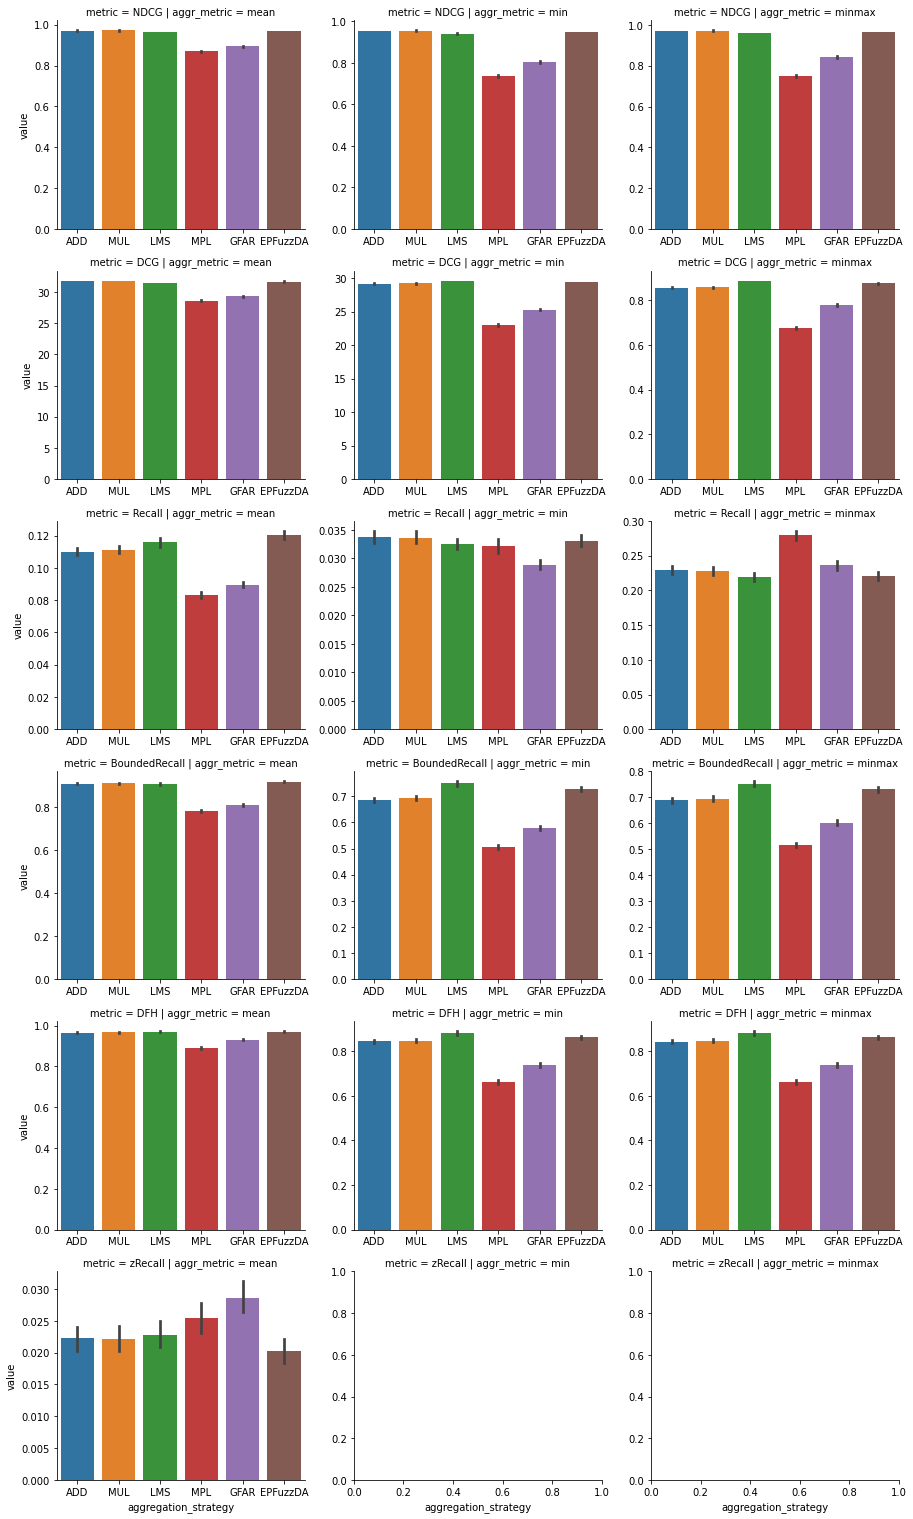

In [12]:
all_group_res = eval_df.groupby(['metric', 'aggr_metric', 'aggregation_strategy']).mean().reset_index()

g = sns.catplot(data=eval_df, row="metric", col="aggr_metric", 
                   x="aggregation_strategy", y="value", sharex=False, sharey=False,
                   kind="bar",  height=3.5, aspect=1.2)

In [10]:
group_composition_DF = pd.DataFrame(group_composition).T
eval_df_with_group_info = group_composition_DF.join(eval_df.set_index("group_id"))
eval_df_with_group_info.head()

group_size group_similarity group_members metric aggr_metric     value  \
0          2           random  [4805, 5428]   NDCG        mean  0.021379   
0          2           random  [4805, 5428]   NDCG         min  0.000000   
0          2           random  [4805, 5428]   NDCG      minmax  0.000000   
0          2           random  [4805, 5428]    DCG        mean  0.150515   
0          2           random  [4805, 5428]    DCG         min  0.000000   

  aggregation_strategy  current_fold  
0                  ADD             0  
0                  ADD             0  
0                  ADD             0  
0                  ADD             0  
0                  ADD             0

### Metric variance per group size; keeping the aggregation strategies visible

C:\Users\lpeska\anaconda3\lib\site-packages\seaborn\categorical.py:3793: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


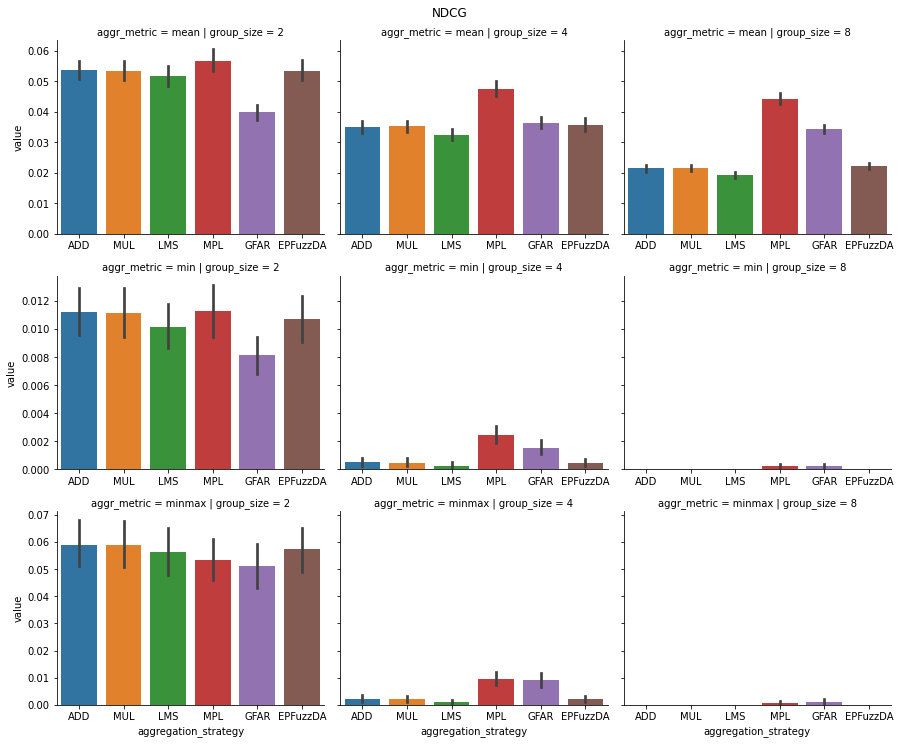

In [11]:
metric = "NDCG"
g = sns.catplot(data=eval_df_with_group_info.loc[eval_df_with_group_info.metric==metric], col="group_size", row="aggr_metric", 
                   x="aggregation_strategy", y="value", sharex=False, sharey="row",
                   kind="bar",  height=3.5, aspect=1.2)
plt.suptitle(metric)
plt.tight_layout()


### Metric variance per group size; merging all aggregation strategies

C:\Users\lpeska\anaconda3\lib\site-packages\seaborn\categorical.py:3793: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


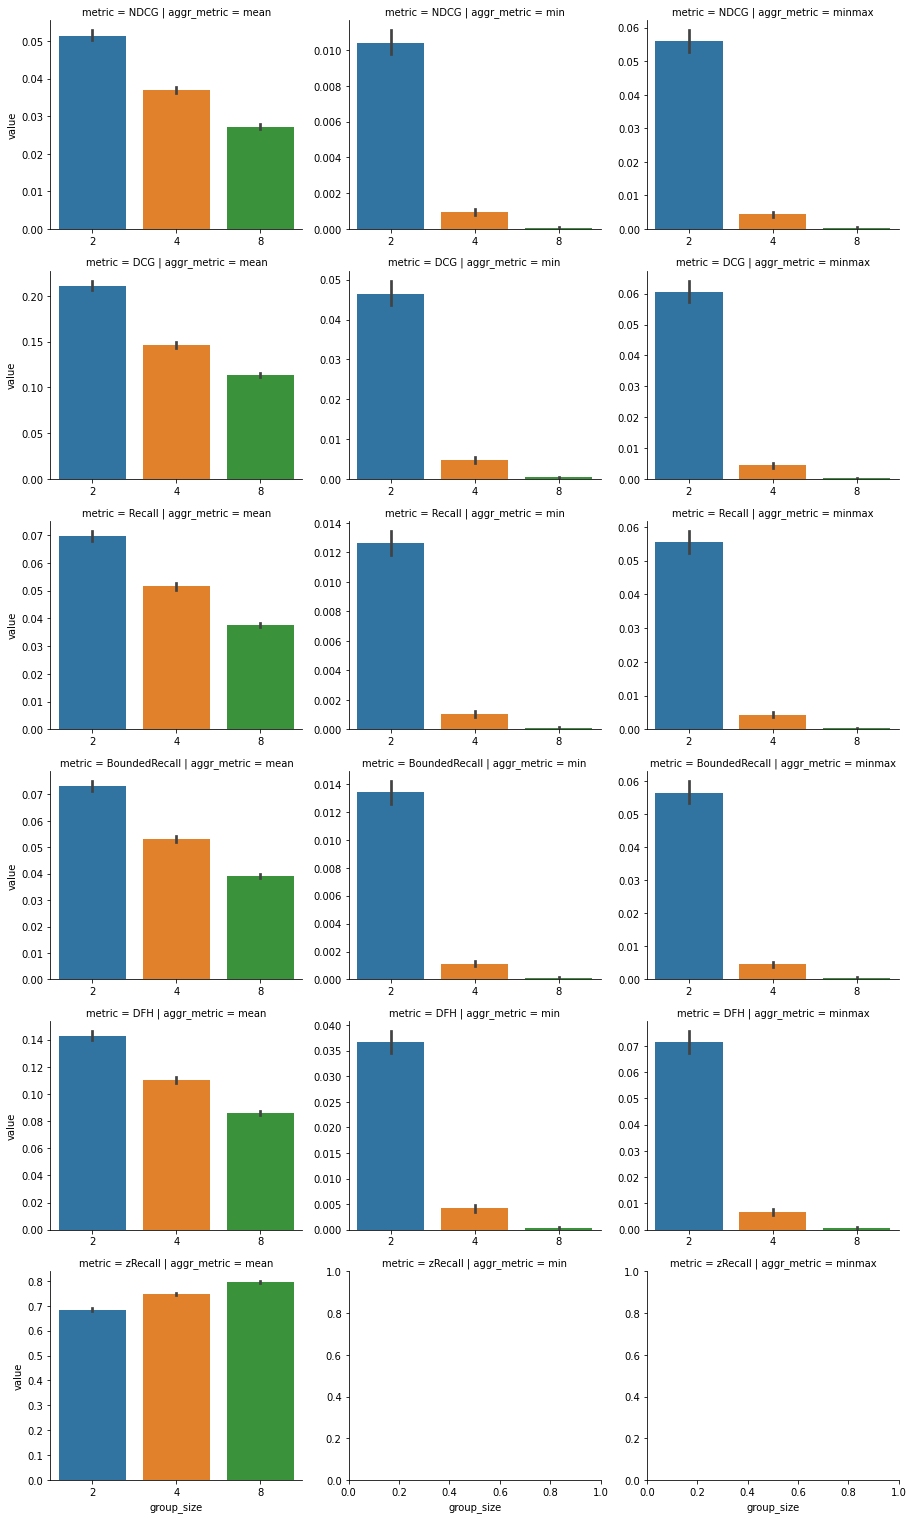

In [12]:
g = sns.catplot(data=eval_df_with_group_info, row="metric", col="aggr_metric", 
                   x="group_size", y="value", sharex=False, sharey=False,
                   kind="bar",  height=3.5, aspect=1.2)


### Metric variance per group size and group type; merging all aggregation strategies

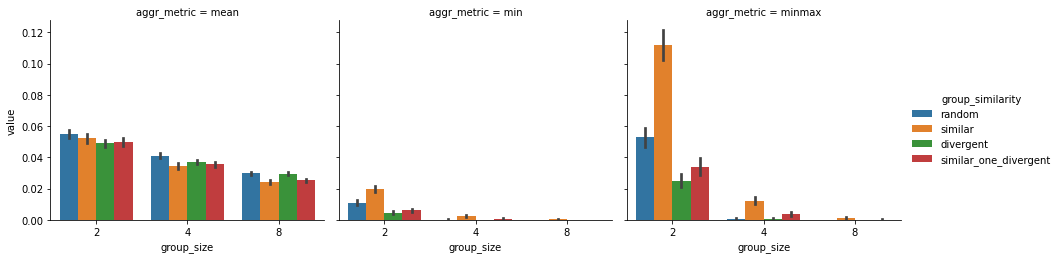

In [13]:
metric = "NDCG"
g = sns.catplot(data=eval_df_with_group_info.loc[eval_df_with_group_info.metric==metric], hue="group_similarity", col="aggr_metric", 
                   x="group_size", y="value", sharex=False, sharey="row",
                   kind="bar",  height=3.5, aspect=1.2)

### Depict distribution of per-group values for all metrics

C:\Users\lpeska\anaconda3\lib\site-packages\seaborn\categorical.py:3793: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


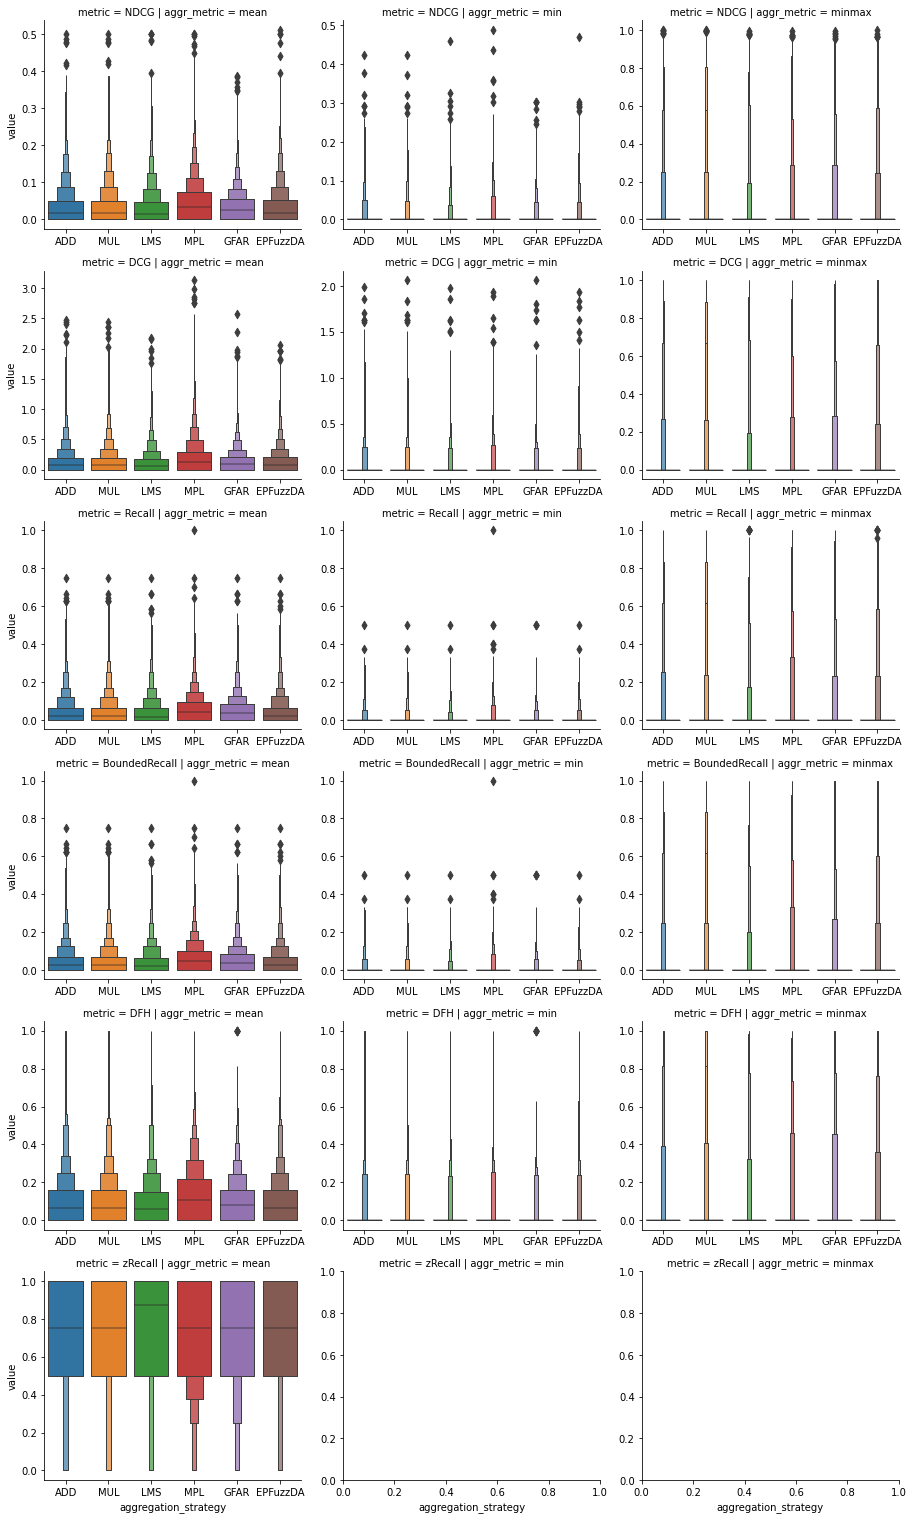

In [14]:
g = sns.catplot(data=eval_df, row="metric", col="aggr_metric", 
                   x="aggregation_strategy", y="value", sharex=False, sharey=False,
                   kind="boxen",  height=3.5, aspect=1.2)

In [18]:
#group_folds = eval_df.groupby(['metric', 'aggr_metric', 'aggregation_strategy', 'group_id']).mean()
#display(group_folds['value'].reset_index().sort_values(by='group_id'))

In [19]:
#eval_df.groupby(['metric', 'aggr_metric', 'aggregation_strategy']).mean().head(50)

# Compare results of multiple evaluation runs
### Collect all results and extend eval_df with relevant evaluation parameters

In [21]:
#get all evaluation runs specified in valid_rows
def get_valid_evaluation_data(valid_rows):
    eval_df_list = []
    for res in valid_rows:
        path_to_eval_folder = preprocessed_dataset_folder + "/" + res
        eval_df = pickle.load(open(path_to_eval_folder+"/eval_df.pkl", "rb"))    
        for c in parameters_df_relevant.columns:
            eval_df[c]=parameters_df_relevant.loc[res,c]
        eval_df_list.append(eval_df)

    eval_df_concat = pd.concat(eval_df_list)
    return eval_df_concat

In [26]:
#select only those evaluation runs we consider interesting
valid_rows = parameters_df_relevant.index[:4]
parameters_df_relevant.loc[valid_rows]

evaluation_strategy inverse_propensity_debiasing  \
eval_1663280669.8002677             COUPLED                        False   
eval_1663281533.6065123             COUPLED                        False   
eval_1663282398.1663923             COUPLED                        False   
eval_1663283262.6141398             COUPLED                        False   

                        inverse_propensity_gamma binarize_feedback  \
eval_1663280669.8002677                      0.0              True   
eval_1663281533.6065123                      0.0              True   
eval_1663282398.1663923                      0.0              True   
eval_1663283262.6141398                      0.0              True   

                        binarize_feedback_positive_threshold  \
eval_1663280669.8002677                                  5.0   
eval_1663281533.6065123                                  4.0   
eval_1663282398.1663923                                  3.0   
eval_1663283262.6141398                                  2.0   

                        feedback_polarity_debiasing  
eval_1663280669.8002677                         2.0  
eval_1663281533.6065123                         2.0  
eval_1663282398.1663923                         2.0  
eval_1663283262.6141398                         2.0

In [27]:
eval_df_concat = get_valid_evaluation_data(valid_rows)
eval_df_concat.head(3)

metric aggr_metric     value aggregation_strategy  group_id  current_fold  \
0   NDCG        mean  0.021379                  ADD         0             0   
1   NDCG         min  0.000000                  ADD         0             0   
2   NDCG      minmax  0.000000                  ADD         0             0   

  evaluation_strategy inverse_propensity_debiasing inverse_propensity_gamma  \
0             COUPLED                        False                      0.0   
1             COUPLED                        False                      0.0   
2             COUPLED                        False                      0.0   

  binarize_feedback binarize_feedback_positive_threshold  \
0              True                                  5.0   
1              True                                  5.0   
2              True                                  5.0   

  feedback_polarity_debiasing  
0                         2.0  
1                         2.0  
2                         2.0

### Coupled evaluation: effect of feedback binarization and inverse propensity debiasing

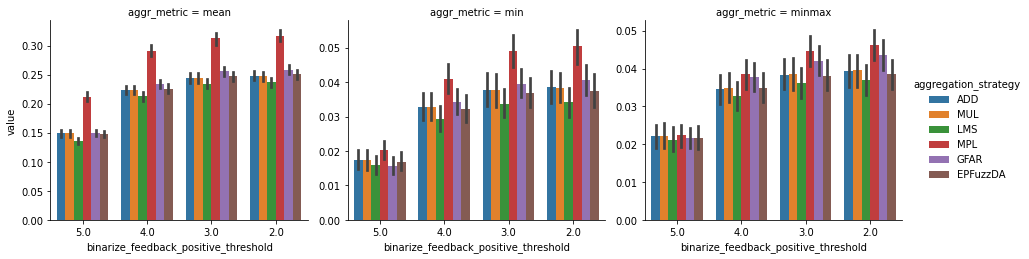

In [28]:
metric = "DCG"
g = sns.catplot(data=eval_df_concat.loc[eval_df_concat.metric==metric], x="binarize_feedback_positive_threshold", 
                col="aggr_metric", 
                hue="aggregation_strategy", y="value", sharex="col", sharey=False,
                kind="bar",  height=3.5, aspect=1.2)

In [34]:
#select only those evaluation runs we consider interesting
valid_rows = parameters_df_relevant.index[[1,4,5,6,7]]
eval_df_concat = get_valid_evaluation_data(valid_rows)
parameters_df_relevant.loc[valid_rows]

evaluation_strategy inverse_propensity_debiasing  \
eval_1663281533.6065123             COUPLED                        False   
eval_1663284373.157593              COUPLED                         True   
eval_1663285470.9824817             COUPLED                         True   
eval_1663286563.1802847             COUPLED                         True   
eval_1663287655.3001313             COUPLED                         True   

                        inverse_propensity_gamma binarize_feedback  \
eval_1663281533.6065123                      0.0              True   
eval_1663284373.157593                       0.1              True   
eval_1663285470.9824817                      0.5              True   
eval_1663286563.1802847                      1.0              True   
eval_1663287655.3001313                      2.0              True   

                        binarize_feedback_positive_threshold  \
eval_1663281533.6065123                                  4.0   
eval_1663284373.157593                                   4.0   
eval_1663285470.9824817                                  4.0   
eval_1663286563.1802847                                  4.0   
eval_1663287655.3001313                                  4.0   

                        feedback_polarity_debiasing  
eval_1663281533.6065123                         2.0  
eval_1663284373.157593                          2.0  
eval_1663285470.9824817                         2.0  
eval_1663286563.1802847                         2.0  
eval_1663287655.3001313                         2.0

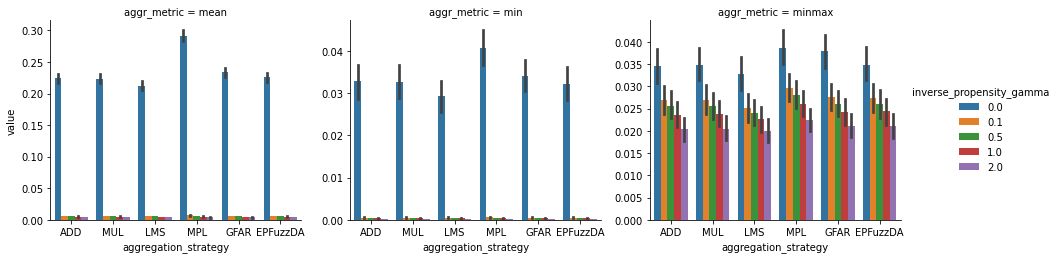

In [35]:
metric = "DCG"
g = sns.catplot(data=eval_df_concat.loc[eval_df_concat.metric==metric],  
                col="aggr_metric", hue="inverse_propensity_gamma", 
                x="aggregation_strategy", y="value", sharex=False, sharey=False,
                kind="bar",  height=3.5, aspect=1.2)

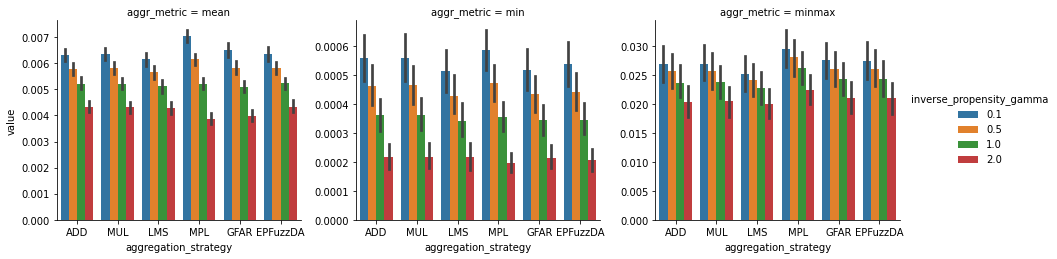

In [37]:
valid_rows = parameters_df_relevant.index[[4,5,6,7]]
eval_df_concat = get_valid_evaluation_data(valid_rows)
metric = "DCG"
g = sns.catplot(data=eval_df_concat.loc[eval_df_concat.metric==metric],  
                col="aggr_metric", hue="inverse_propensity_gamma", 
                x="aggregation_strategy", y="value", sharex=False, sharey=False,
                kind="bar",  height=3.5, aspect=1.2)

### Decoupled evaluation: effect of polarity debiasing

In [39]:
valid_rows = parameters_df_relevant.index[11:15]
eval_df_concat = get_valid_evaluation_data(valid_rows)
parameters_df_relevant.loc[valid_rows]

evaluation_strategy inverse_propensity_debiasing  \
eval_1663298606.152506            DECOUPLED                         True   
eval_1663303136.2728064           DECOUPLED                         True   
eval_1663307731.5719433           DECOUPLED                         True   
eval_1663436168.0032027           DECOUPLED                         True   

                        inverse_propensity_gamma binarize_feedback  \
eval_1663298606.152506                       0.5             False   
eval_1663303136.2728064                      0.5             False   
eval_1663307731.5719433                      0.5             False   
eval_1663436168.0032027                      0.5             False   

                        binarize_feedback_positive_threshold  \
eval_1663298606.152506                                   4.0   
eval_1663303136.2728064                                  4.0   
eval_1663307731.5719433                                  4.0   
eval_1663436168.0032027                                  4.0   

                        feedback_polarity_debiasing  
eval_1663298606.152506                          0.0  
eval_1663303136.2728064                        -2.0  
eval_1663307731.5719433                        -4.0  
eval_1663436168.0032027                        -5.0

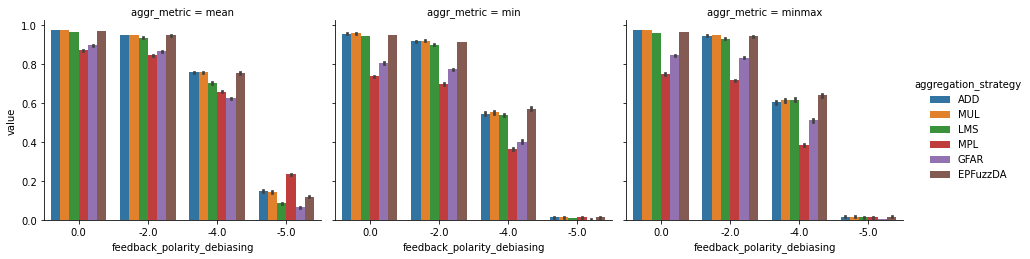

In [40]:
metric = "NDCG"
g = sns.catplot(data=eval_df_concat.loc[eval_df_concat.metric==metric], x="feedback_polarity_debiasing", 
                col="aggr_metric", 
                hue="aggregation_strategy", y="value", sharex=False, sharey="row",
                kind="bar",  height=3.5, aspect=1.2)

In [44]:
valid_rows = parameters_df_relevant.index[[10,15,16]]
eval_df_concat = get_valid_evaluation_data(valid_rows)
parameters_df_relevant.loc[valid_rows]

evaluation_strategy inverse_propensity_debiasing  \
eval_1663294119.2699444           DECOUPLED                         True   
eval_1663441335.4183762           DECOUPLED                         True   
eval_1663446476.9394755           DECOUPLED                         True   

                        inverse_propensity_gamma binarize_feedback  \
eval_1663294119.2699444                      0.5              True   
eval_1663441335.4183762                      0.5              True   
eval_1663446476.9394755                      0.5              True   

                        binarize_feedback_positive_threshold  \
eval_1663294119.2699444                                  4.0   
eval_1663441335.4183762                                  3.0   
eval_1663446476.9394755                                  5.0   

                        feedback_polarity_debiasing  
eval_1663294119.2699444                         0.0  
eval_1663441335.4183762                         0.0  
eval_1663446476.9394755                         0.0

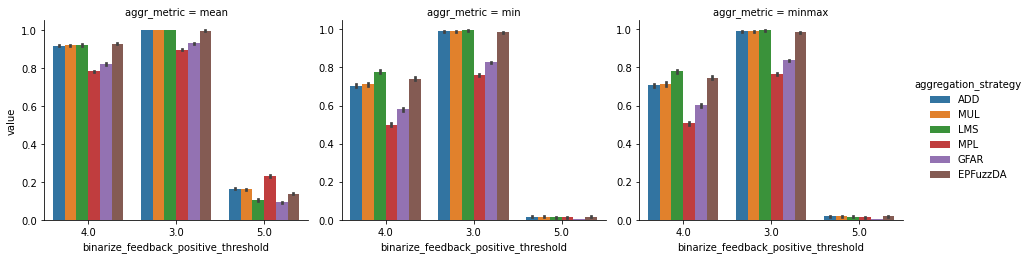

In [45]:
metric = "NDCG"
g = sns.catplot(data=eval_df_concat.loc[eval_df_concat.metric==metric], x="binarize_feedback_positive_threshold", 
                col="aggr_metric", 
                hue="aggregation_strategy", y="value", sharex=False, sharey=False,
                kind="bar",  height=3.5, aspect=1.2)